<a href="https://colab.research.google.com/github/dishant9210/Max_Health/blob/main/MaxHealthAssignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Arrays in dataset: ['x_train', 'y_train', 'x_val', 'y_val']
x_train shape: (7007, 28, 28, 3)
y_train shape: (7007, 1)
y_train shape: 116


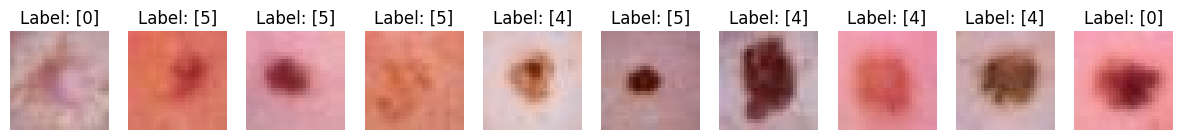

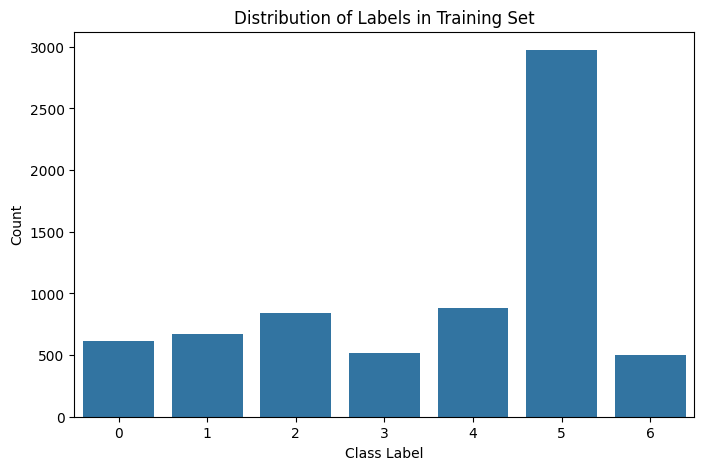

Starting Robust Training with GCE...
Epoch 1/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - accuracy: 0.2398 - loss: 1.0707 - val_accuracy: 0.0339 - val_loss: 1.1127
Epoch 2/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.3112 - loss: 1.0373 - val_accuracy: 0.1047 - val_loss: 1.2060
Epoch 3/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3139 - loss: 1.0356 - val_accuracy: 0.1615 - val_loss: 1.0854
Epoch 4/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3220 - loss: 1.0303 - val_accuracy: 0.1695 - val_loss: 1.1105
Epoch 5/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.3196 - loss: 1.0296 - val_accuracy: 0.4327 - val_loss: 0.9468
Epoch 6/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.3293 - loss: 1.0342 - val_accuracy: 0.2981 - val_loss: 1.0337
Epoch 7/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.3323 - loss: 1.0221 - val_accuracy: 0.4796 - val_loss: 0.8526
Epoch 8/50
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accu

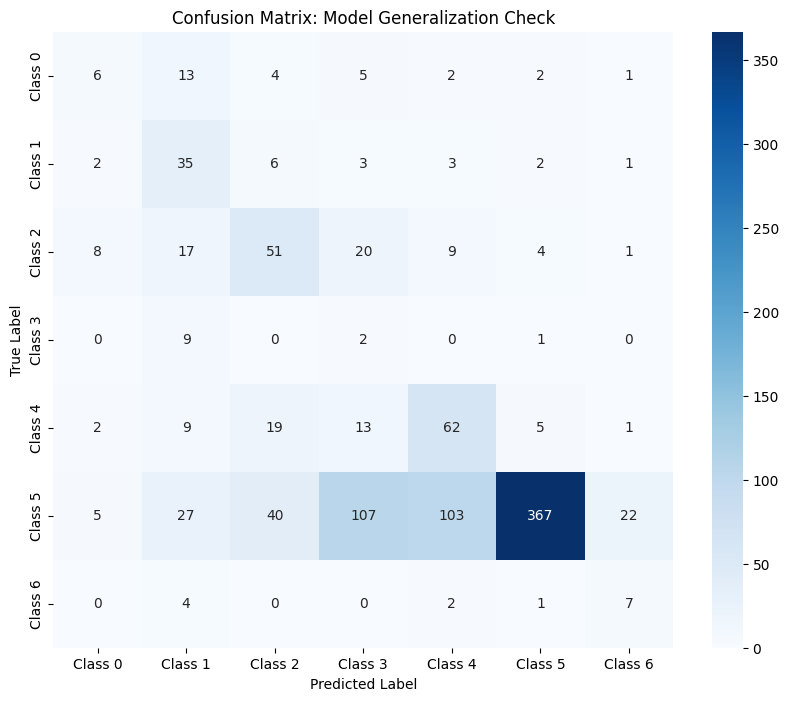


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.26      0.18      0.21        33
           1       0.31      0.67      0.42        52
           2       0.42      0.46      0.44       110
           3       0.01      0.17      0.02        12
           4       0.34      0.56      0.42       111
           5       0.96      0.55      0.70       671
           6       0.21      0.50      0.30        14

    accuracy                           0.53      1003
   macro avg       0.36      0.44      0.36      1003
weighted avg       0.75      0.53      0.60      1003



In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = np.load('/content/candidate_dataset.npz') # Modified path to /content/

# List all files (arrays) in the .npz archive
print("Arrays in dataset:", data.files)

# Extract typical arrays
x_train = data['x_train']
y_train = data['y_train']
# x_test = data['x_test']
# y_test = data['y_test']

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_train shape: {x_train[0][0][1][1]}")

# Function to plot sample images
def plot_samples(X, y, n=10):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(X[i])
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.show()

plot_samples(x_train, y_train)

# Plot the distribution of labels
plt.figure(figsize=(8, 5))
sns.countplot(x=y_train.ravel()) # Flatten y_train to a 1D array
plt.title("Distribution of Labels in Training Set")
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.show()

import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, callbacks # Added models and layers imports
import numpy as np # Import numpy for data loading

# 1. Custom Robust Loss: Generalized Cross Entropy (GCE)
class GeneralizedCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, q=0.7, num_classes=7, name='gce_loss', **kwargs):
        super().__init__(name=name, **kwargs)
        self.q = q
        self.num_classes = num_classes

    # Removed @tf.function decorator here, Keras will manage graph compilation for loss functions.
    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1]) # Ensure y_true is 1D for sparse labels
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
        p_y = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        loss = (1.0 - tf.pow(p_y, self.q)) / self.q
        return loss

    def get_config(self):
        config = super().get_config()
        config.update({"q": self.q, "num_classes": self.num_classes})
        return config

# Re-load data and prepare datasets with flattened labels for consistency
data = np.load('/content/candidate_dataset.npz')
x_train, y_train = data['x_train'], data['y_train'].ravel() # Flatten y_train
x_val, y_val = data['x_val'], data['y_val'].ravel() # Flatten y_val

def prepare_ds(x, y, batch_size=64, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((x, y))
    if shuffle:
        ds = ds.shuffle(1000)
    # Explicitly set output shapes for robustness, especially for labels
    ds = ds.map(lambda xi, yi: (xi, tf.cast(yi, tf.int32)))
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_ds = prepare_ds(x_train, y_train, shuffle=True)
val_ds = prepare_ds(x_val, y_val)

# Class weights to handle imbalance discovered in EDA (re-use from previous cell)
class_weight_dict = {0: 1.62, 1: 1.49, 2: 1.18, 3: 1.92, 4: 1.13, 5: 0.33, 6: 2.00}

# 2. Robust Model Architecture
# We add more regularization (higher Dropout) to complement the Robust Loss
def build_robust_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 3)),
        layers.Rescaling(1./255),

        # Data Augmentation layer (Internal to model for easier Live Inference)
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),

        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5), # Increased dropout for noise robustness
        layers.Dense(7, activation='softmax')
    ])
    return model

# 3. Robust Configuration
robust_model = build_robust_model()
robust_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=GeneralizedCrossEntropy(q=0.7),
    metrics=['accuracy']
)

# 4. Execution with Early Stopping
# Professional models always use callbacks to prevent overfitting to noise
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("Starting Robust Training with GCE...")
history_robust = robust_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stop]
)

robust_model.save("robust_gce_model.keras")

import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K # Import K for K.epsilon()

# Define the custom loss class here to ensure it's available for model loading
class GeneralizedCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, q=0.7, num_classes=7, name='gce_loss', **kwargs):
        super().__init__(name=name, **kwargs) # Pass name and other kwargs to the base class
        self.q = q
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1]) # Ensure y_true is 1D
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
        p_y = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        return (1.0 - tf.pow(p_y, self.q)) / self.q

    def get_config(self):
        # Implement get_config to serialize custom parameters
        config = super().get_config()
        config.update({"q": self.q, "num_classes": self.num_classes})
        return config

def run_evaluation(model_path  , data_path  ):
    # 1. Load the model
    # Note: We must tell Keras how to handle our custom GCE loss
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'GeneralizedCrossEntropy': GeneralizedCrossEntropy}
    )

    # 2. Load the dataset
    data = np.load(data_path)

    # 3. Handle different possible key names (x_val/y_val or x_test/y_test)
    x_test = data.get('x_test', data.get('x_val'))
    y_test = data.get('y_test', data.get('y_val'))

    if x_test is None or y_test is None:
        raise ValueError(f"Could not find test/val keys in {data_path}. "
                         "Expected 'x_val'/'y_val' or 'x_test'/'y_test'.")

    # 4. Run prediction
    # Our model includes the Rescaling(1./255) layer, so we pass raw images
    print(f"Evaluating model on: {data_path}...")
    loss, accuracy = model.evaluate(x_test, y_test, verbose=1)

    print("\n" + "="*30)
    print(f"FINAL TEST ACCURACY: {accuracy*100:.2f}%")
    print(f"FINAL TEST LOSS: {loss:.4f}")
    print("="*30)

    return accuracy

# --- HOW TO RUN THIS ---
# To test it yourself right now:
run_evaluation('robust_gce_model.keras', 'candidate_dataset.npz')

# To run it during the interview:
# run_evaluation('robust_gce_model.keras', 'the_name_of_the_file_they_give_you.npz')

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import backend as K
from sklearn.metrics import confusion_matrix, classification_report

# 1. Define the custom class again (Mandatory for loading)
class GeneralizedCrossEntropy(tf.keras.losses.Loss):
    def __init__(self, q=0.7, num_classes=7, name="gce_loss", **kwargs):
        super().__init__(name=name, **kwargs)
        self.q = q
        self.num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1.0)
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.reshape(y_true, [-1])
        y_true_one_hot = tf.one_hot(y_true, depth=self.num_classes)
        p_y = tf.reduce_sum(y_true_one_hot * y_pred, axis=-1)
        return (1.0 - tf.pow(p_y, self.q)) / self.q

    def get_config(self):
        config = super().get_config()
        config.update({"q": self.q, "num_classes": self.num_classes})
        return config

# 2. The Plotting Function
def plot_confusion_matrix(model_path, data_path):
    # Load model with custom objects
    model = tf.keras.models.load_model(
        model_path,
        custom_objects={'GeneralizedCrossEntropy': GeneralizedCrossEntropy}
    )

    # Load validation data
    data = np.load(data_path)
    x_val = data['x_val']
    y_val = data['y_val'].flatten()

    # Get predictions
    print("Generating predictions...")
    y_pred_probs = model.predict(x_val)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Generate Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)

    # Plotting
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=[f'Class {i}' for i in range(7)],
                yticklabels=[f'Class {i}' for i in range(7)])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix: Model Generalization Check')
    plt.show()

    # Print metrics for each class
    print("\nDetailed Classification Report:")
    print(classification_report(y_val, y_pred, zero_division=0))

# 3. Execution
plot_confusion_matrix('robust_gce_model.keras', 'candidate_dataset.npz')